# Instalación de librerias o dependencias externas

In [96]:
# instalamos librerias necesarias
!pip install openrouteservice
!pip install geopandas
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
## importamos librerias 
import openrouteservice as ors
from time import sleep
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import imageio
import io

# Definición de clase para el algoritmo de hormigas

In [98]:
# Referencia del algoritmo utilizado: "https://github.com/Akavall/AntColonyOptimization/blob/c585c5cfc9b0e6b709322ac15fe1e2193b20d8e4/ant_colony.py"

import random as rn
import numpy as np
from numpy.random import choice as np_choice

class AntColony(object):

    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        Example:
            ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone = self.pheromone * self.decay            
        return all_time_shortest_path

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

# Inicialización de los datos

In [108]:
## definimos las constantes de los lugares
locaciones = [
    "Palmira, Valle del cauca, Colombia", 
    "Pasto, Nariño, Colombia", "Tulua, Valle del cauca, Colombia", 
    "Bogota, Colombia", "Pereira, Risaralda, Colombia", 
    "Armenia, Quindio, Colombia",
    "Manizales, Caldas, Colombia", "Valledupar, Cesar, Colombia",
    "Monteria, Cordoba, Colombia", "Soledad, Atlantico, Colombia",
    "Cartagena, Bolivar, Colombia", "Barranquilla, Atlantico, Colombia" ,
    "Medellin, Antioquia, Colombia", "Bucaramanga, Santander, Colombia", 
    "Cucuta, Norte de Santander, Colombia"
]

## definimos el precio de la gasolina
PRECIO_GASOLINA_POR_GALON = 10766
VIAJE_POR_GALON = 58 * 1000
VELOCIDAD_MAXIMA = 80 * 1000
SALARIO_VENDEDOR = 7690

In [100]:
## obtenemos la información de los peajes generada

## iniciamos sesión
auth.authenticate_user()

creds, _ = default()

gc = gspread.authorize(creds)

## obtenemos la hoja en especifico
worksheet = gc.open('Peajes').get_worksheet(2)

# obtenemos los valores
rows = worksheet.get_all_values()

# lo convertimos en un dataframe
peajes_info = pd.DataFrame.from_records(rows)
header_row = peajes_info.iloc[0]
peajes_info = pd.DataFrame(peajes_info.values[1:], columns=header_row)

In [101]:
## definimos credenciales para iniciar sesión en la libreria que permite calcular la distancia entre dos puntos
# Crea una instancia del cliente de OpenRouteService
client = ors.Client(key='5b3ce3597851110001cf624833b2ae6b8901451ea538eee59fbd6132')

# Cálculo de las coordenadas y las distancias entre ciudades

In [109]:
## definimos funcion para obtener las locaciones, recibe un listado de municipios y devuelve un diccionario con la información de las coordenadas del lugar, 
## la cantidad en kilometros y el municipio de origen a fin

def guardar_coordenada(coordenadas: object = {}, city: str = '', coordenada = tuple):
  doesExistsCoordenada = coordenadas.get(city)

  if(doesExistsCoordenada == None):
    coordenadas[city] = {
      "coordenada": tuple(coordenada),
    }

def obtener_grafo_locaciones(municipios: list = []):
  tamano_lista = len(municipios)
  results = {}
  coordenadas = {}
  
  for start_city in municipios:
    copy_municipios = list.copy(municipios)
    copy_municipios.remove(start_city)

    start_coords = client.pelias_search(start_city)['features'][0]['geometry']['coordinates']
    guardar_coordenada(coordenadas, start_city, start_coords)
    for end_city in copy_municipios:
      doesExistsInResults = results.get(f"{end_city}_{start_city}")

      if(not doesExistsInResults):
        sleep(1)
        end_coords = client.pelias_search(end_city)['features'][0]['geometry']['coordinates']
        guardar_coordenada(coordenadas, end_city, end_coords)

        route = client.directions(coordinates=[start_coords, end_coords], profile='driving-car', format='geojson',)
        ruta = route['features'][0]['properties']['segments'][0]['distance']
        results[f"{start_city}_{end_city}"] = {
            "municipio_inicial": start_city,
            "municipio_final": end_city,
            "coordenada_inicial": start_coords,
            "coordenada_final": end_coords,
            "ruta": ruta,
        }


  return (results, coordenadas)

In [103]:
rutas_con_distancia, coordenadas  = obtener_grafo_locaciones(locaciones)

In [104]:
coordenadas

{'Palmira, Valle del cauca, Colombia': {'coordenada': (-76.30361, 3.53944)},
 'Pasto, Nariño, Colombia': {'coordenada': (-77.28111, 1.21361)},
 'Tulua, Valle del cauca, Colombia': {'coordenada': (-76.19536, 4.08466)},
 'Bogota, Colombia': {'coordenada': (-74.08768, 4.635456)},
 'Pereira, Risaralda, Colombia': {'coordenada': (-75.685157, 4.812095)},
 'Armenia, Quindio, Colombia': {'coordenada': (-75.68111, 4.53389)},
 'Manizales, Caldas, Colombia': {'coordenada': (-75.504741, 5.065894)},
 'Valledupar, Cesar, Colombia': {'coordenada': (-73.25322, 10.46314)},
 'Monteria, Cordoba, Colombia': {'coordenada': (-75.879135, 8.763871)},
 'Soledad, Atlantico, Colombia': {'coordenada': (-74.76459, 10.91843)},
 'Cartagena, Bolivar, Colombia': {'coordenada': (-75.546862, 10.423583)},
 'Barranquilla, Atlantico, Colombia': {'coordenada': (-74.784913, 10.987333)},
 'Medellin, Antioquia, Colombia': {'coordenada': (-75.576955, 6.276949)},
 'Bucaramanga, Santander, Colombia': {'coordenada': (-73.118251, 7

# Calculamos la ruta más optima según el costo total

In [110]:
def generate_distance(municipios: list = []):
  distancias = []
  for start_place in locaciones:
    distancia_local = []
    for end_place in locaciones:
      if(start_place == end_place):
        distancia_local.append(np.inf)
      else:
        result_1 = rutas_con_distancia.get(f"{end_place}_{start_place}") 
        result_2 = rutas_con_distancia.get(f"{start_place}_{end_place}")
        resultado_parcial =  result_1 if result_1 else result_2
        if(resultado_parcial != None):
          distancia = resultado_parcial.get("ruta")
          gasolina_gastada = distancia / VIAJE_POR_GALON
          costo_gasolina = PRECIO_GASOLINA_POR_GALON * gasolina_gastada
          data_peaje_ruta = peajes_info.loc[(peajes_info['inicio'].isin([start_place, end_place])) & (peajes_info["fin"].isin([start_place, end_place])) ]
          indice = data_peaje_ruta.index[0]
          costo_peaje = data_peaje_ruta["precio_total"][indice]
          cantidad_horas_viaje = distancia / VELOCIDAD_MAXIMA
          costo_horas = cantidad_horas_viaje * SALARIO_VENDEDOR

          distancia_local.append((costo_horas + costo_gasolina + float(costo_peaje)))
        else: 
          distancia_local.append(np.inf)
    distancias.append(distancia_local)
  return distancias
      

distancias = generate_distance(locaciones)
distancias = np.array(distancias)

ant_colony = AntColony(distancias, 150, 150, 1000, 0.95, alpha=1, beta=1)
shortest_path = ant_colony.run()
print (shortest_path)

([(0, 2), (2, 4), (4, 6), (6, 12), (12, 8), (8, 10), (10, 11), (11, 9), (9, 7), (7, 14), (14, 13), (13, 3), (3, 5), (5, 1), (1, 0)], 1751100.5480625)


# Graficamos en el mapa de colombia el resultado obtenido

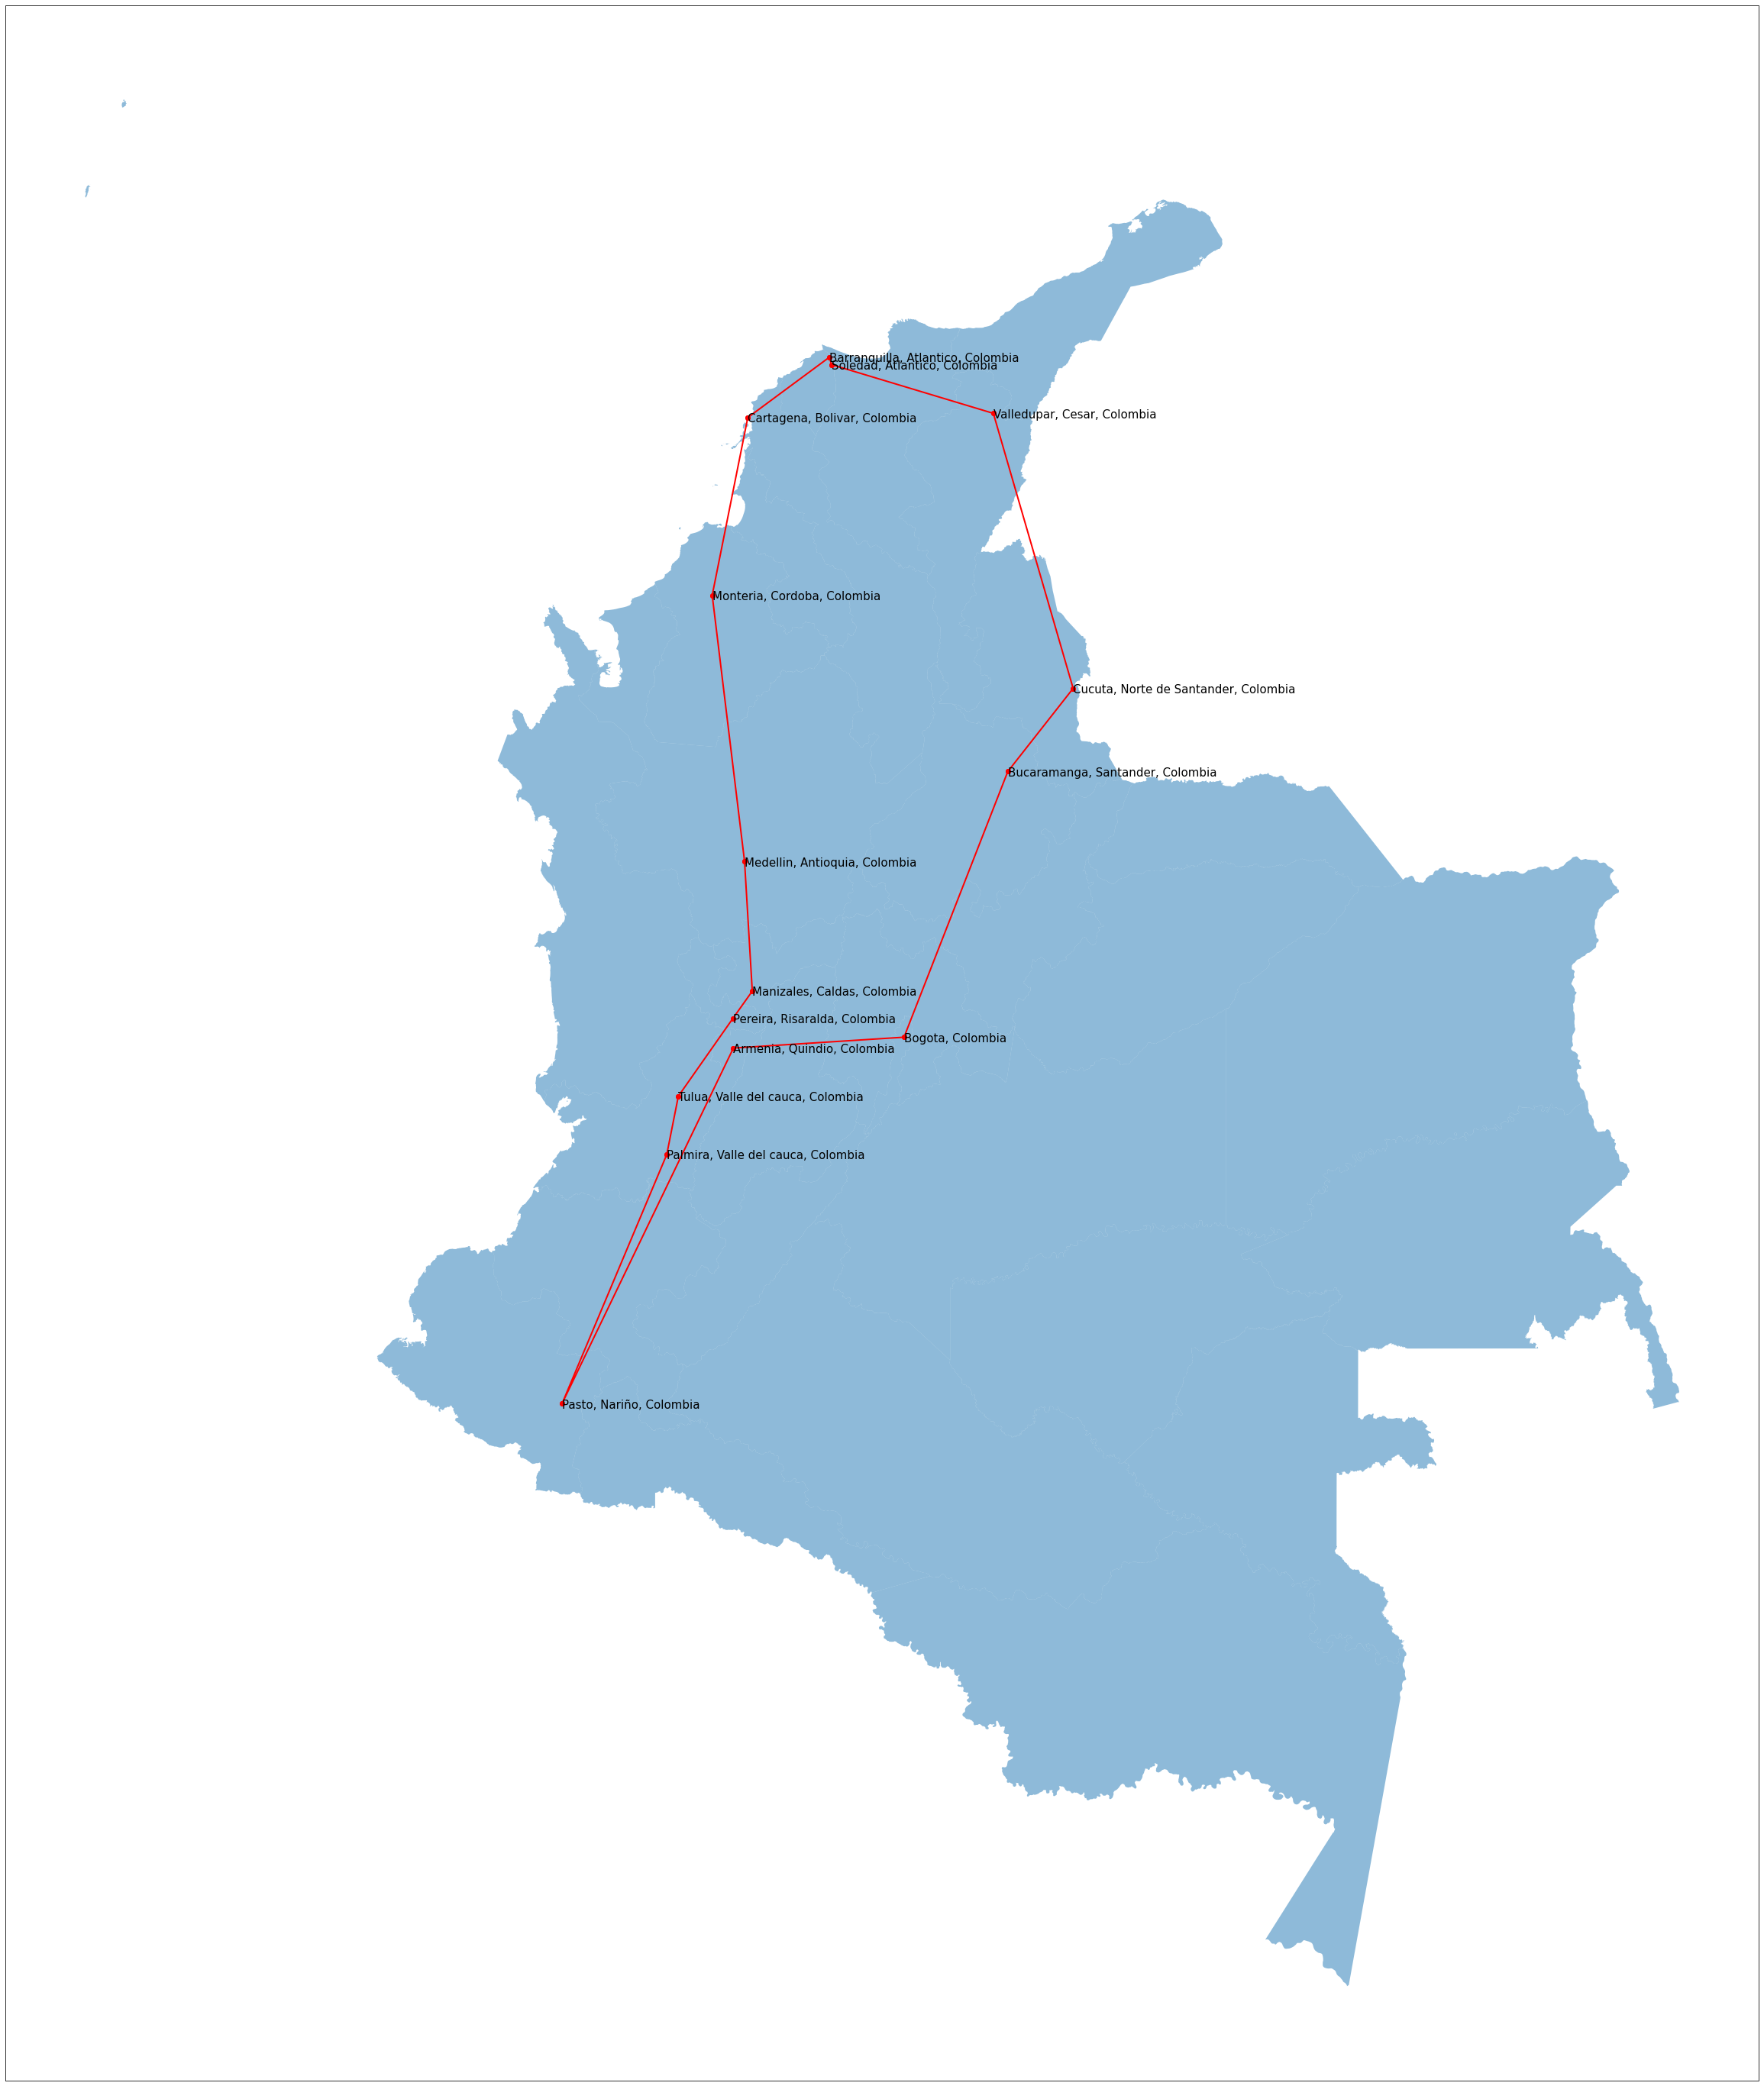

In [111]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import imageio
import io

# cargar el mapa de Colombia
colombia = gpd.read_file('mapa_colombia.shp')

# establecer la figura y los ejes
fig = plt.figure(figsize=(50, 50))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# trazar el mapa de Colombia
colombia.plot(ax=ax, alpha=0.5)


# establecer los puntos que se unirán con una línea
puntos = [(-75.579156,6.244203), (-76.68106, 7.66638), (-73.119796,1.142295)]

# convertir los puntos a un arreglo numpy


# trazar la línea que une los puntos
line, = ax.plot([], [], 'o-', color='red', lw=2)


coordenadas_array = []
for city in locaciones:
  coordenada = coordenadas.get(city).get("coordenada")
  coordenadas_array.append(coordenada)
  ax.text(coordenada[0], coordenada[1], city, transform=ccrs.PlateCarree(), ha='left', va='center_baseline', fontsize=15)

ruta_optima = []
for item in shortest_path[0]:
  lugar_1 = item[0]
  lugar_2 = item[1]
  ruta_optima.append(coordenadas_array[lugar_1])
  ruta_optima.append(coordenadas_array[lugar_2])

puntos = np.array(ruta_optima)


# guardar las imágenes para el gif animado
images = []

# iterar sobre los puntos y actualizar la línea
for i in range(1, len(puntos) + 1):
    # establecer los puntos de la línea
    line.set_data(puntos[:i, 0], puntos[:i, 1])
    
    # guardar la imagen actual
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    images.append(imageio.imread(buf))
    
# guardar el gif animado
imageio.mimsave('linea_colombia.gif', images, fps=2)